# Training process 2
+ Model name：`Training_2_Res_NLLLoss_1FC_50e.pt` ; 
+ Path： '`./model/Formal_training_process1_model_resnet50_nnloss_sp.pt`'
+ Training network：`resnet50 with One fully connected layers`
+ Loss function：`NLLLoss`
+ Optimizer： `Adam`
+ epoch： `50`
+ sample pairing: `False `

### Data Preparation

In [1]:
import torch
import torchvision
from torchvision import datasets,transforms 
from face_crop import face_crop # 调module下的函数


train_dir = './data/face_data/train/'
valid_dir = './data/face_data/val/'

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    face_crop(),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std),
    transforms.RandomErasing(),
])


valid_transform = transforms.Compose([
    face_crop(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std),
])

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=256,
                                           shuffle=True, num_workers=4)


valid_data = datasets.ImageFolder(root=valid_dir,
                                transform=valid_transform)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=256,
                                          shuffle=True, num_workers=4)


In [2]:
train_data

Dataset ImageFolder
    Number of datapoints: 10481
    Root location: ./data/face_data/train/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=(-10, 10), resample=False, expand=False)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [3]:
valid_data

Dataset ImageFolder
    Number of datapoints: 6821
    Root location: ./data/face_data/val/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [4]:
class_names = train_data.classes

/home/wang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  app.launch_new_instance()


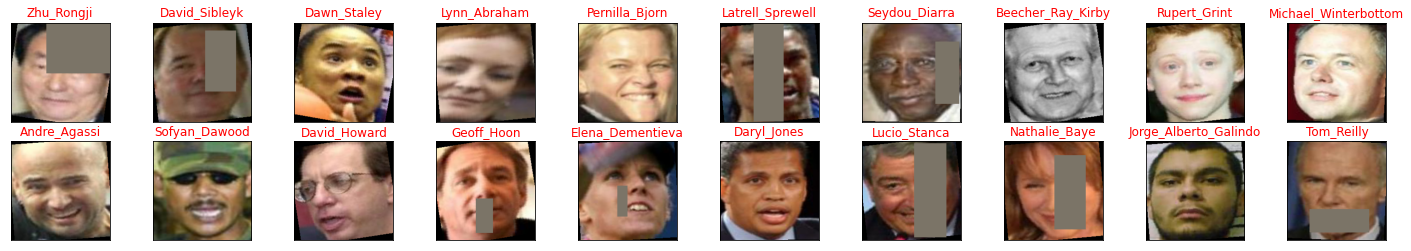

In [5]:
#Transform Data visualize
import numpy as np
import matplotlib.pyplot as plt
images, classes = next(iter(train_loader))

def imshow(inp):
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    

fig = plt.figure(figsize=(25, 4))
    # display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(class_names[classes[idx]], color='red') 

### Training Network

In [6]:
# Resnet50 with One fully connected layers
from torchvision import models
from torch import nn
from collections import OrderedDict

model_resnet50 = models.resnet50(pretrained=True)
for param in model_resnet50.parameters():
    param.requires_grad = False

classifier = nn.Sequential(OrderedDict([
    ('fc', nn.Linear(2048, len(class_names))),
    ('output', nn.LogSoftmax(dim=1))
]))

# Replace the classifier part of the introduced net!
model_resnet50.fc = classifier

In [7]:
# model_resnet50

## Trainning process

In [8]:
import torch 
import torch.nn.functional as F
from torch import nn, optim  
from tqdm import tqdm
import numpy as np
from focal_loss import FocalLoss

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train(model='resnet50', data_augumentation=False, loss='NLLLoss', lr=0.003, weight_decay=1e-5, epoch=None):
    if model == 'model_resnet50':
        model = model_resnet50
    
    model.to(device)
    
    if data_augumentation:
        pass
        
    if loss == 'NLLLoss':
        print('use NLLLoss')
        criterion = nn.NLLLoss()
        
    if loss == 'FocalLoss':
        print('use focal loss')
        criterion = FocalLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)    
    
    
    epochs = epoch
    train_losses, valid_losses = [], []
    valid_loss_min = np.inf

    for e in range(epochs):
        train_loss = 0
        valid_loss = 0
        accuracy = 0.0

        model.train()
        for images, labels in tqdm(train_loader):
            if data_augumentation == 'samplePairing' and e+1 >= epochs * 0.2 and e+1 < epochs * 0.8:
                # do sample pairing for every image
                for i in range(images.shape[0]):
                    image_sample = SamplePairing()
                    image_a = images[i]
                    image_b = images[np.random.randint(0, images.shape[0])]
                    # images[i] is of type tensor, and both inputs are of type tensor
                    images[i] = image_sample(image_a, image_b)
                    
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            log_ps = model(images)
            loss = criterion(log_ps, labels)
            loss = loss.requires_grad_()
            loss.backward()

            optimizer.step()
            train_loss += loss.item() * images.size(0)

        model.eval()  # Close dropout
        with torch.no_grad():
            for images, labels in tqdm(valid_loader):
                images, labels = images.to(device), labels.to(device)
                
                # Verify loss
                log_ps = model(images)
                loss = criterion(log_ps, labels)
                valid_loss += loss.item() * images.size(0)
                
                # Verify accuracy
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        # An epoch loss 
        train_loss = train_loss/len(train_loader.sampler)   
        valid_loss = valid_loss/len(valid_loader.sampler)
        valid_accuracy = accuracy / len(valid_loader)

        # Add the loss to the list for graphing
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
        # Add the code to save this list to the local to use this loss transformation list when not training in the future, 
        # such as comparing different models
        train_loss_array = np.array(train_losses)
        valid_loss_array = np.array(valid_losses)
        valid_accuracy_array = np.array(valid_accuracy)
        
        
        np.save('./results/Training_2/Ftp2_train_loss_array.npy', train_loss_array)
        np.save('./results/Training_2/Ftp2_valid_loss_array.npy', valid_loss_array)
        np.save('./results/Training_2/Ftp2_valid_accuracy_array.npy', valid_accuracy_array)
        
   
        # Print an epoch information
        print('Epoch {}/{}..'.format(e + 1, epochs),
              'Train loss:{:.4f}..'.format(train_loss),
              'Valid loss:{:.4f}..'.format(valid_loss),
              'Valid accuracy:{:.4f}%..'.format(valid_accuracy * 100))
        
        # Save the optimal model
        if valid_loss <= valid_loss_min:
            print('valid_loss decreased: ({:.4f} --> {:.4f}), saving model "Training_2_Res_NLLLoss_1FC_50e.pt"..'.format(valid_loss_min, valid_loss))
            torch.save(model, './model/Training_2_Res_NLLLoss_1FC_50e.pt')
            valid_loss_min = valid_loss

In [15]:
train(model='model_resnet50', data_augumentation=False, loss='NLLoss', lr=0.003, weight_decay=1e-5, epoch=50)

100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [03:29<00:00,  7.76s/it]


Epoch 1/50.. Train loss:12.5460.. Valid loss:9.6156.. Valid accuracy:2.1587%..
valid_loss decreased: (inf --> 9.6156), saving model "Formal training process1 model_resnet50_light"..


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [03:21<00:00,  7.45s/it]


Epoch 2/50.. Train loss:9.2604.. Valid loss:8.7669.. Valid accuracy:4.0105%..
valid_loss decreased: (9.6156 --> 8.7669), saving model "Formal training process1 model_resnet50_light"..


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [03:24<00:00,  7.56s/it]


Epoch 3/50.. Train loss:8.2492.. Valid loss:7.8190.. Valid accuracy:8.5608%..
valid_loss decreased: (8.7669 --> 7.8190), saving model "Formal training process1 model_resnet50_light"..


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [03:17<00:00,  7.32s/it]


Epoch 4/50.. Train loss:7.3914.. Valid loss:6.9938.. Valid accuracy:15.2617%..
valid_loss decreased: (7.8190 --> 6.9938), saving model "Formal training process1 model_resnet50_light"..


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [03:23<00:00,  7.55s/it]


Epoch 5/50.. Train loss:6.5854.. Valid loss:6.3099.. Valid accuracy:19.6150%..
valid_loss decreased: (6.9938 --> 6.3099), saving model "Formal training process1 model_resnet50_light"..


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [03:19<00:00,  7.39s/it]


Epoch 6/50.. Train loss:5.9292.. Valid loss:5.8754.. Valid accuracy:24.6073%..
valid_loss decreased: (6.3099 --> 5.8754), saving model "Formal training process1 model_resnet50_light"..


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [03:21<00:00,  7.45s/it]


Epoch 7/50.. Train loss:5.3177.. Valid loss:5.3059.. Valid accuracy:31.2318%..
valid_loss decreased: (5.8754 --> 5.3059), saving model "Formal training process1 model_resnet50_light"..


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [03:21<00:00,  7.47s/it]


Epoch 8/50.. Train loss:4.7373.. Valid loss:4.8841.. Valid accuracy:37.2035%..
valid_loss decreased: (5.3059 --> 4.8841), saving model "Formal training process1 model_resnet50_light"..


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [03:18<00:00,  7.36s/it]


Epoch 9/50.. Train loss:4.3471.. Valid loss:4.5720.. Valid accuracy:39.7772%..
valid_loss decreased: (4.8841 --> 4.5720), saving model "Formal training process1 model_resnet50_light"..


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [03:17<00:00,  7.31s/it]


Epoch 10/50.. Train loss:4.0046.. Valid loss:4.3340.. Valid accuracy:44.7435%..
valid_loss decreased: (4.5720 --> 4.3340), saving model "Formal training process1 model_resnet50_light"..


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [03:17<00:00,  7.33s/it]


Epoch 11/50.. Train loss:3.6773.. Valid loss:4.2179.. Valid accuracy:45.7119%..
valid_loss decreased: (4.3340 --> 4.2179), saving model "Formal training process1 model_resnet50_light"..


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [03:23<00:00,  7.53s/it]


Epoch 12/50.. Train loss:3.3389.. Valid loss:4.0816.. Valid accuracy:49.2843%..
valid_loss decreased: (4.2179 --> 4.0816), saving model "Formal training process1 model_resnet50_light"..


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [03:21<00:00,  7.45s/it]


Epoch 13/50.. Train loss:3.1626.. Valid loss:3.8759.. Valid accuracy:51.7822%..
valid_loss decreased: (4.0816 --> 3.8759), saving model "Formal training process1 model_resnet50_light"..


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [03:18<00:00,  7.37s/it]


Epoch 14/50.. Train loss:2.9538.. Valid loss:3.8058.. Valid accuracy:52.6942%..
valid_loss decreased: (3.8759 --> 3.8058), saving model "Formal training process1 model_resnet50_light"..


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [03:16<00:00,  7.28s/it]


Epoch 15/50.. Train loss:2.8006.. Valid loss:3.7915.. Valid accuracy:53.6830%..
valid_loss decreased: (3.8058 --> 3.7915), saving model "Formal training process1 model_resnet50_light"..


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [03:20<00:00,  7.42s/it]


Epoch 16/50.. Train loss:2.7093.. Valid loss:3.7602.. Valid accuracy:54.6962%..
valid_loss decreased: (3.7915 --> 3.7602), saving model "Formal training process1 model_resnet50_light"..


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [03:22<00:00,  7.49s/it]


Epoch 17/50.. Train loss:2.6019.. Valid loss:3.7310.. Valid accuracy:54.5426%..
valid_loss decreased: (3.7602 --> 3.7310), saving model "Formal training process1 model_resnet50_light"..


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [03:22<00:00,  7.49s/it]


Epoch 18/50.. Train loss:2.4938.. Valid loss:3.6452.. Valid accuracy:56.3770%..
valid_loss decreased: (3.7310 --> 3.6452), saving model "Formal training process1 model_resnet50_light"..


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [03:19<00:00,  7.39s/it]


Epoch 19/50.. Train loss:2.3780.. Valid loss:3.6195.. Valid accuracy:57.8182%..
valid_loss decreased: (3.6452 --> 3.6195), saving model "Formal training process1 model_resnet50_light"..


  0%|                                                                                           | 0/41 [00:00<?, ?it/s]

Epoch 20/50.. Train loss:2.3764.. Valid loss:3.6393.. Valid accuracy:56.9906%..


  0%|                                                                                           | 0/41 [00:00<?, ?it/s]

Epoch 21/50.. Train loss:2.2768.. Valid loss:3.6409.. Valid accuracy:57.5483%..


  0%|                                                                                           | 0/41 [00:00<?, ?it/s]

Epoch 22/50.. Train loss:2.2317.. Valid loss:3.6921.. Valid accuracy:57.2341%..


  0%|                                                                                           | 0/41 [00:00<?, ?it/s]

Epoch 23/50.. Train loss:2.1844.. Valid loss:3.6885.. Valid accuracy:57.8102%..


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [03:17<00:00,  7.32s/it]


Epoch 24/50.. Train loss:2.1672.. Valid loss:3.5782.. Valid accuracy:59.4525%..
valid_loss decreased: (3.6195 --> 3.5782), saving model "Formal training process1 model_resnet50_light"..


  0%|                                                                                           | 0/41 [00:00<?, ?it/s]

Epoch 25/50.. Train loss:2.0564.. Valid loss:3.6701.. Valid accuracy:58.6543%..


  0%|                                                                                           | 0/41 [00:00<?, ?it/s]

Epoch 26/50.. Train loss:2.0324.. Valid loss:3.7148.. Valid accuracy:59.0849%..


  0%|                                                                                           | 0/41 [00:00<?, ?it/s]

Epoch 27/50.. Train loss:2.0060.. Valid loss:3.6664.. Valid accuracy:59.1682%..


  0%|                                                                                           | 0/41 [00:00<?, ?it/s]

Epoch 28/50.. Train loss:1.9908.. Valid loss:3.5882.. Valid accuracy:60.2273%..


  0%|                                                                                           | 0/41 [00:00<?, ?it/s]

Epoch 29/50.. Train loss:1.9298.. Valid loss:3.7004.. Valid accuracy:59.0355%..


  0%|                                                                                           | 0/41 [00:00<?, ?it/s]

Epoch 30/50.. Train loss:1.9016.. Valid loss:3.5908.. Valid accuracy:60.5072%..


  0%|                                                                                           | 0/41 [00:00<?, ?it/s]

Epoch 31/50.. Train loss:1.8659.. Valid loss:3.6847.. Valid accuracy:59.9918%..


  0%|                                                                                           | 0/41 [00:00<?, ?it/s]

Epoch 32/50.. Train loss:1.8780.. Valid loss:3.7075.. Valid accuracy:59.9384%..


  0%|                                                                                           | 0/41 [00:00<?, ?it/s]

Epoch 33/50.. Train loss:1.8451.. Valid loss:3.6091.. Valid accuracy:60.4508%..


  0%|                                                                                           | 0/41 [00:00<?, ?it/s]

Epoch 34/50.. Train loss:1.8432.. Valid loss:3.7425.. Valid accuracy:60.3600%..


  0%|                                                                                           | 0/41 [00:00<?, ?it/s]

Epoch 35/50.. Train loss:1.8335.. Valid loss:3.7432.. Valid accuracy:60.4014%..


  0%|                                                                                           | 0/41 [00:00<?, ?it/s]

Epoch 36/50.. Train loss:1.7853.. Valid loss:3.7916.. Valid accuracy:60.5296%..


  0%|                                                                                           | 0/41 [00:00<?, ?it/s]

Epoch 37/50.. Train loss:1.7867.. Valid loss:3.7437.. Valid accuracy:59.8606%..


  0%|                                                                                           | 0/41 [00:00<?, ?it/s]

Epoch 38/50.. Train loss:1.7569.. Valid loss:3.7861.. Valid accuracy:60.7870%..


  0%|                                                                                           | 0/41 [00:00<?, ?it/s]

Epoch 39/50.. Train loss:1.7597.. Valid loss:3.7554.. Valid accuracy:60.9911%..


  0%|                                                                                           | 0/41 [00:00<?, ?it/s]

Epoch 40/50.. Train loss:1.7266.. Valid loss:3.7379.. Valid accuracy:60.9816%..


  0%|                                                                                           | 0/41 [00:00<?, ?it/s]

Epoch 41/50.. Train loss:1.7361.. Valid loss:3.7467.. Valid accuracy:61.0519%..


  0%|                                                                                           | 0/41 [00:00<?, ?it/s]

Epoch 42/50.. Train loss:1.6832.. Valid loss:3.7805.. Valid accuracy:60.9258%..


  0%|                                                                                           | 0/41 [00:00<?, ?it/s]

Epoch 43/50.. Train loss:1.6764.. Valid loss:3.9149.. Valid accuracy:60.2278%..


  0%|                                                                                           | 0/41 [00:00<?, ?it/s]

Epoch 44/50.. Train loss:1.7156.. Valid loss:3.8286.. Valid accuracy:61.0445%..


  0%|                                                                                           | 0/41 [00:00<?, ?it/s]

Epoch 45/50.. Train loss:1.6967.. Valid loss:3.8838.. Valid accuracy:60.4268%..


  0%|                                                                                           | 0/41 [00:00<?, ?it/s]

Epoch 46/50.. Train loss:1.6799.. Valid loss:3.8942.. Valid accuracy:60.7646%..


  0%|                                                                                           | 0/41 [00:00<?, ?it/s]

Epoch 47/50.. Train loss:1.7021.. Valid loss:3.8195.. Valid accuracy:61.6132%..


  0%|                                                                                           | 0/41 [00:00<?, ?it/s]

Epoch 48/50.. Train loss:1.6985.. Valid loss:3.8688.. Valid accuracy:61.7529%..


  0%|                                                                                           | 0/41 [00:00<?, ?it/s]

Epoch 49/50.. Train loss:1.7065.. Valid loss:3.8765.. Valid accuracy:61.8656%..


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [03:28<00:00,  7.73s/it]

Epoch 50/50.. Train loss:1.6760.. Valid loss:3.9253.. Valid accuracy:61.0454%..


### Loss visualization

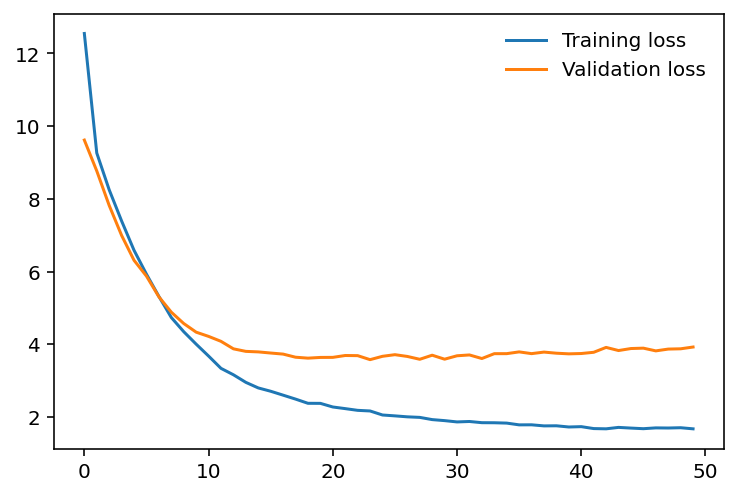

In [17]:
train_losses = np.load('./results/Training_2/Ftp2_train_loss_array.npy')
valid_losses = np.load('./results/Training_2/Ftp2_valid_loss_array.npy')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False) 

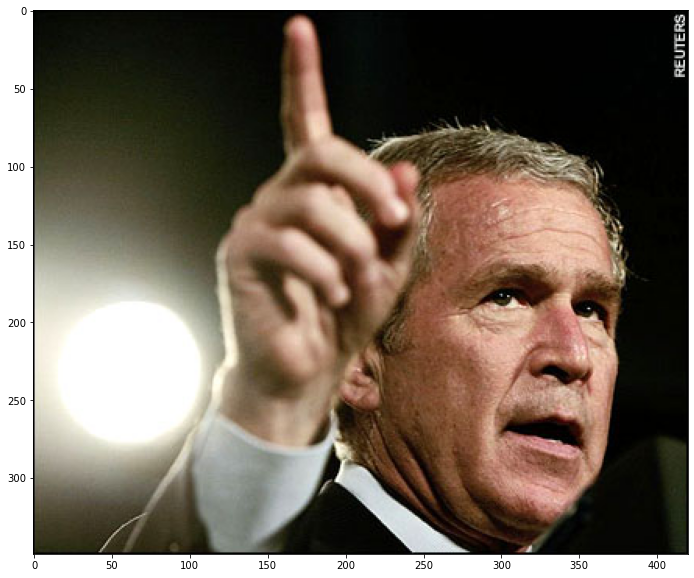

In [9]:
img_path = './data/face_test/big_bushi2.jpg'

# Read test picture
from PIL import Image, ImageDraw
%matplotlib inline
import matplotlib.pyplot as plt 

plt.figure(figsize=(48, 10)) # Set canvas size

img = Image.open(img_path)
plt.imshow(img)

In [19]:
import torch
model_path = './model/Training_2_Res_NLLLoss_1FC_50e.pt'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model
model=torch.load(model_path)
model.to(device);

In [20]:
from face_crop import face_crop
from torchvision import datasets,transforms 
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

img = Image.open(img_path)

valid_transform = transforms.Compose([
    face_crop(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std),
])



transformed_image = valid_transform(img).float()
with torch.no_grad():
    transformed_image = transformed_image
    transformed_image = transformed_image.unsqueeze(0)
    transformed_image = transformed_image.to(device)
    outputs = model(transformed_image)
#         plt.imshow(transformed_image)
#         print(transformed_image)
outputs = torch.exp(outputs)

In [21]:
top_p, top_k = torch.topk(outputs, 10, dim=1, largest=True, sorted=True, out=None)

In [22]:
import numpy as np
class_names = np.load("class_names.npy")

In [23]:
print('The most similar person is {}.'.format(class_names[top_k[0][0].item()]))
print('Similarity is {:.2%}'.format(top_p[0][0].item()))
print('\n')
print('The second similar person is {}.'.format(class_names[top_k[0][1].item()]))
print('Similarity is {:.2%}'.format(top_p[0][1].item()))
print('\n')
print('The third similar person is {}.'.format(class_names[top_k[0][2].item()]))
print('Similarity is {:.2%}'.format(top_p[0][2].item()))

The most similar person is George_W_Bush.
Similarity is 35.73%


The second similar person is Tom_Ridge.
Similarity is 6.65%


The third similar person is Geoff_Hoon.
Similarity is 6.23%
